## openCV를 통해 모니터에 카메라 화면 출력

In [ ]:
import cv2

video = cv2.VideoCapture('http://192.168.0.109:81/stream')
frame_size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))

while True:
    ret, frame = video.read()
    if not ret:
        break

    cv2.imshow('ESP32-CAM', frame)

    # Press 'Esc' to stop
    key = cv2.waitKey(25)
    if key == 27:
        break

if video.isOpened():
    video.release()

cv2.destroyAllWindows()

## 카메라 모듈 화면 표시 & 얼굴인식

In [ ]:
from imutils.video import VideoStream
from imutils import face_utils
import argparse
import imutils
import time
import dlib
import cv2
import easydict
 
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-p", "--shape-predictor", required=True,
#     help="/home/behan/3_1/current_circuit/shape_predictor_68_face_landmarks.dat")
# args = vars(ap.parse_args())
 
args = easydict.EasyDict({"shape_predictor": "./shape_predictor_68_face_landmarks.dat"})
 
# initialize dlib's face detector (HOG-based) and then create the
# facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])
 
# initialize the video stream and sleep for a bit, allowing the
# camera sensor to warm up
print("[INFO] camera sensor warming up...")
#vs = VideoStream(src=0).start()
# vs = VideoStream(usePiCamera=True).start() # Raspberry Pi
# time.sleep(2.0)
 
video = cv2.VideoCapture('http://192.168.0.109:81/stream')
frame_size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
 
# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream, resize it to
    # have a maximum width of 400 pixels, and convert it to
    # grayscale
    # frame = vs.read()
    ret, frame = video.read()
    if not ret:
        print("video road fail!!!")
        break
    # frame = imutils.resize(frame, width=400)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
    # detect faces in the grayscale frame
    rects = detector(gray, 0)
 
    # check to see if a face was detected, and if so, draw the total
    # number of faces on the frame
    if len(rects) > 0:
        text = "{} face(s) found".format(len(rects))
        cv2.putText(frame, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
            0.5, (0, 0, 255), 2)
 
    # loop over the face detections
    for rect in rects:
        # compute the bounding box of the face and draw it on the
        # frame
        (bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
        cv2.rectangle(frame, (bX, bY), (bX + bW, bY + bH),
            (0, 255, 0), 1)
 
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
 
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw each of them
        for (i, (x, y)) in enumerate(shape):
            cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
            cv2.putText(frame, str(i + 1), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
 
    # show the frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
 
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
# vs.stop()

## 아두이노 시리얼 통신 pyserial

In [ ]:
# 파이썬에서 아두이노로 데이터 보내기

import serial
import time


# "COM3"부분에 환경에 맞는 포트 입력
ser = serial.Serial('/dev/cu.usbmodem2017_2_251', 9600)


while True:
    if ser.readable():
        val = input()

        if (val == '1'):
            val = val.encode('utf-8') #보내기전 encoding
            ser.write(val)
            print("LED ON")
            time.sleep(0.5)
        elif (val == '0'):
            val = val.encode('utf-8')
            ser.write(val)
            print("LED OFF")
            time.sleep(0.5)
        else:
            print("end")
            break

In [ ]:
#아두이노에서 파이썬으로 데이터 입력받기

import serial
import time

ser = serial.Serial('/dev/cu.usbmodem2017_2_251', 9600)

while True:
    if ser.readable():
        val = ser.readline()
        print(val.decode())
    

## 실험 4: 휘스톤브릿지 압력센서 아두이노로 연결, 저장, 데이터 시각화

### 필요 함수 정의

##### cal_resistance(r1, r2, r3, vin, vout) : 휘스톤 브릿지로 측정한 저압을 저항으로 계산
        - r1: 휘스톤 브릿지의 R_1
        - r2: 휘스톤 브릿지의 R_2
        - r3: 휘스톤 브릿지의 R_3
        - vin: 휘스톤 브릿지의 V_in
        - vout: 휘스톤 브릿지의 V_out(Va - Vb)

##### save_csv(v_out, resistance) : v_out과 resistance를 csv파일로 저장
        - v_out: 휘스톤브릿지의 v_out을 리스트 타입으로 입력
        - resistance: v_out 리스트의 각 값들을 cal_resistance 함수로 계산한 리스트

##### draw_plt(file_path) : 저장한 csv 파일을 불러와 matplot으로 그린다.
        - file_path: csv 파일이 저장된 주소를 string으로 입력

In [50]:
import sympy
import pandas as pd
import matplotlib.pyplot as plt

#휘스톤 브릿지로 측정한 전압을 저항으로 변경 함수
def cal_resistance(r1,r2,r3,vin,vout):  
    x = sympy.symbols('x')
    eq = (r3+x)*(r2*vin)-(x*vin)*(r1+r2)-vout*(r1+r2)*(r3+x)
    result = sympy.solve(eq)
    result = int(result[0]*1000 + 0.5) / 1000
    return result

#측정 데이터(전압)과 저항으로 계산한 값을 csv 파일로 저장
def save_csv(splited_val):
    data = {
        "v_a": splited_val[0],
        "v_b": splited_val[1],
        "v_out": splited_val[2],
        "resistance": splited_val[3]
    }
    df = pd.DataFrame(data)
    df.to_csv('output.csv', index=False, encoding='cp949')

# 저장한 csv파일을 읽고 matplot으로 그리기
def draw_plt(file_path, ax_1, ax_2):
    read_data = pd.read_csv(file_path)
    
    read_data["Vout_calculate"] = (10000/(10000+10000)-read_data["Resistance"]/(10000+read_data["Resistance"]))*5
    
    fig, ax1 = plt.subplots()
    line_1 = ax1.plot(read_data[ax_1], color='green', label='Vout')
    ax1.set_xlabel("pressure")
    ax1.set_ylabel("Vout")

    ax2 = plt.twinx()
    line_2 = ax2.plot(read_data[ax_2], color='red', label='Resistance')
    ax2.set_ylabel("Resistance")
    ax2.set_yscale('log')

    lines = line_1 + line_2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')



In [ ]:
# 실험 4 휘스톤브릿지 전압 측정

import serial
# import time
# import numpy as np
import matplotlib.pyplot as plt
import csv

# ser = serial.Serial('/dev/cu.usbmodem14201', 9600) #serial 연결 "/dev/~~~"는 아두이노 연결된 포트 입력

# ser.close()
# ser.open()

data = serial.Serial('/dev/cu.usbmodem14201', 9600)
f = open('output_value.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['Va','Vb','Vout', 'Resistance'])
f.close()

# value = []
try:            # 아두이노랑 정상통신
    while True:
        # if ser.readable():
        #     read = ser.readline()
        #     val = read[:len(read)-2].decode()       # \r \n 제거
        #     splited_val = val.split(',')
        #     value.append(splited_val)
        #     # v_out.append(val)
        #     print(splited_val)
        s_data = data.readline().decode()[:-2]
        print(s_data)
        l_data = s_data.split(',')
        f = open('output_value.csv', 'a', newline='')
        wr = csv.writer(f)
        wr.writerow(l_data)
        f.close()

            

except:         # 아두이노 종료 or 에러
    ser.close()
    print("serial close.")
    # resistance = [cal_resistance(1000, 1000, 1000, 5, v) for v in v_out]
    # save_csv(value)
    # draw_plt("./output.csv")



In [52]:
import pandas as pd

# Resistance = R1/(-Vout/Vin + R1/(R2+R3))-R1;
R1=10000
R2=10000
R3=10000
Vin=5
df = pd.read_csv("./output_value.csv")
df.head()

# df["-Vout"] = df["Vout"] * -1
# df["Vout_ba"] = df["Vb"] - df["Va"]
# df["Vout_ab"] = df["Va"] - df["Vb"]

# df["Rg_ba"] = R1 / (-df["Vout_ba"]/Vin + R1/(R2+R3))-R1

# df["Rg_ab"] = R1 / (-df["Vout_ab"]/Vin + R1/(R2+R3))-R1
# df["RG_ab"] = (df["Vout_ab"]*R2*(R1 + R2) - Vin*R2*R3) / (R2*Vin - (R1 + R2)*df["Vout_ab"] - (R1 + R2)*Vin)
# df["RG_ba"] = (df["Vout_ba"]*R2*(R1 + R2) - Vin*R2*R3) / (R2*Vin - (R1 + R2)*df["Vout_ba"] - (R1 + R2)*Vin)
# df["Rg_py_ab"] = cal_resistance(R1,R2,R3,5,df["Vout_ab"])
# df["Rg_py_ba"] = cal_resistance(R1,R2,R3,5,df["Vout_ba"])
df["Vout_calculate"] = (R2/(R1+R2)-df["Resistance"]/(R3+df["Resistance"]))*Vin
df["Va-Vb"] = df["Va"]-df["Vb"]
df
# df.tail()

,Va,Vb,Vout,Resistance,Vout_calculate,Va-Vb
0,2.5,4.98,2.48,2550000.00,-2.480469,-2.48
1,2.5,5.00,2.50,inf,NaN,-2.50
2,2.5,4.99,2.49,5110000.00,-2.490234,-2.49
3,2.5,4.58,2.09,111904.77,-2.089844,-2.08
4,2.5,4.04,1.54,42244.90,-1.542969,-1.54
...,...,...,...,...,...,...
794,2.5,1.62,-0.87,4819.10,0.874024,0.88
795,2.5,1.61,-0.88,4776.33,0.883790,0.89
796,2.5,1.64,-0.86,4883.72,0.859375,0.86
797,2.5,1.63,-0.86,4862.12,0.864258,0.87


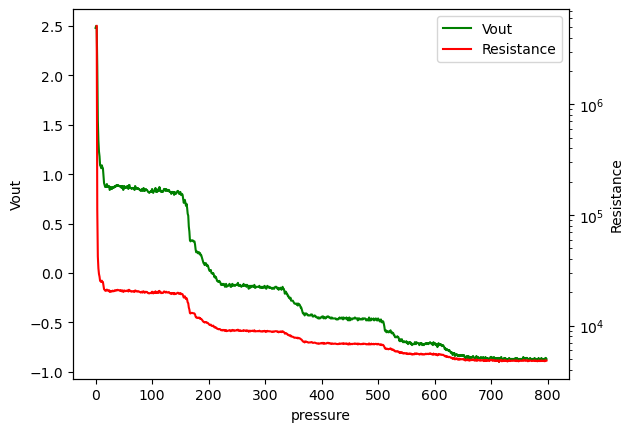

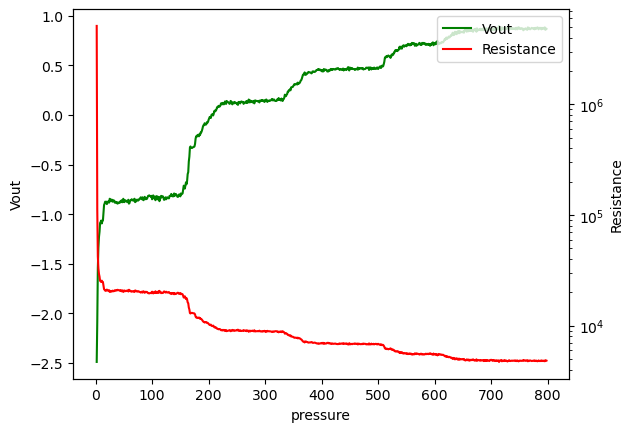

In [56]:
draw_plt("./output_value.csv", "Vout", "Resistance")
draw_plt("./output_value.csv", "Vout_calculate", "Resistance")

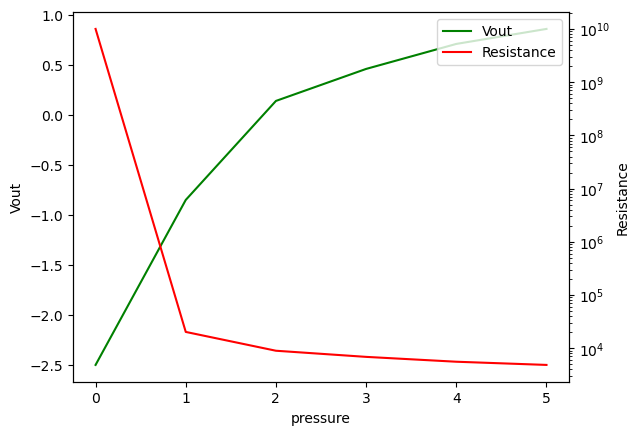

In [65]:
draw_plt("./output_value_2.csv", "Vout", "Resistance")

In [64]:
df = pd.read_csv("./output_value_2.csv")
df

,Va,Vb,Vout,Resistance
0,2.5,5.00,-2.50,1.000000e+10
1,2.5,3.34,-0.85,2.026080e+04
2,2.5,2.36,0.14,8.975340e+03
3,2.5,2.04,0.46,6.882810e+03
4,2.5,1.79,0.71,5.578980e+03
5,2.5,1.63,0.86,4.858930e+03


    v_out    resistance
0  0.0000  1.000000e+07
1  0.3240  1.440832e+04
2  0.4988  9.014021e+03
3  0.6555  6.621952e+03
4  0.7679  5.507028e+03
5  0.8986  4.561117e+03


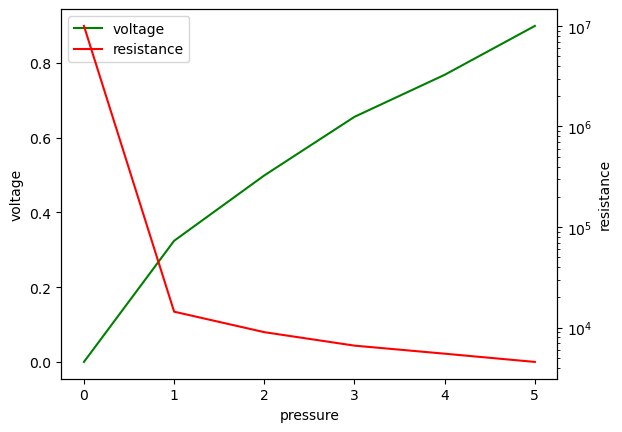

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

force = [0, 10, 20, 30, 40, 50]
v_out = [0, 0.324, 0.4988, 0.6555, 0.7679, 0.8986]
resistance = [cal_resistance(10, 100000, 1000, 5, i) for i in v_out]

data = {
    # "force": force,
    "v_out": v_out,
    "resistance": resistance
}

df = pd.DataFrame(data)
print(df)
df.to_csv('output.csv', index=False, encoding='cp949')


fig, ax1 = plt.subplots()
line_1 = ax1.plot(v_out, color='green', label='voltage')
# ax1.set_yscale('log')
ax1.set_xlabel("pressure")
ax1.set_ylabel("voltage")

ax2 = plt.twinx()
line_2 = ax2.plot(resistance, color='red', label='resistance')
ax2.set_ylabel("resistance")
ax2.set_yscale('log')

lines = line_1 + line_2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()

In [ ]:
read_data = pd.read_csv("./output.csv")
fig, ax1 = plt.subplots()
line_1 = ax1.plot(read_data["v_out"], color='green', label='voltage')
ax1.set_xlabel("pressure")
ax1.set_ylabel("voltage")

ax2 = plt.twinx()
line_2 = ax2.plot(read_data["resistance"], color='red', label='resistance')
ax2.set_ylabel("resistance")

lines = line_1 + line_2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

In [118]:
"1000,100,100".split(",")

['1000', '100', '100']